<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Time Series Modeling

_Author: Matt Brems, Matthew Garton_

---

### Learning Objectives 
_By the end of the lesson, students should be able to:_
- Define forecasting.
- Define and identify trend and seasonality in time series data.
- Define and calculate autocorrelation manually.
- Generate and interpret a seasonal decomposition plot.
- Generate and interpret an autocorrelation plot.
- Generate and interpret a partial autocorrelation plot.
- Properly fit, generate predictions from, and evaluate a linear time series model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Uncomment the code below to avoid a FutureWarning when plotting (or upgrade to matplotlib>=3.3.4)
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

## Forecasting

Our main focus during time series week is not to conduct inference, but to generate forecasts for future values of one or more variables.

<details><summary>What do you think forecasting is?</summary>

- Forecasting is predicting the future as accurately as possible.
</details>

**We should first determine whether or not we want to forecast.**
- Our model's performance will depend on many things:
    - How much data is available.
    - How well we understand factors that contribute to the thing we want to predict. (a.k.a. how predictable is the thing we want to predict!)
    - Whether forecasts can affect what we want to forecast.

### Notation

Imagine a dataset that looks like this:

|  **time**  | $Y_t$ | $Y_{t-1}$ | $Y_{t-2}$ | $Y_{t-3}$ | $X_{t}$ |
|-------|-------|-----------|-----------|-----------|---------|
| **1** | $y_1$ | NaN       | NaN       | NaN       | $x_1$   |
| **2** | $y_2$ | $y_1$     | NaN       | NaN       | $x_2$   |
| **3** | $y_3$ | $y_2$     | $y_1$     | NaN       | $x_3$   |
| **4** | $y_4$ | $y_3$     | $y_2$     | $y_1$     | $x_4$   |

We'll fit models that can help us forecast time series.
- **The thing we want to predict is** $Y_t$.
- We may use $X_t$ to predict $Y_t$.
- We may use $Y_{t-1}$, the value of $Y$ at time $t-1$, to predict $Y_t$.

In [6]:
pd.date_range(start="01/01/2017", end="12-31-2019")

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=1095, freq='D')

In [7]:
# mean = 0, std = 1
np.random.normal()

0.5627313777519763

In [8]:
# Instantiate dataframe with index.
df = pd.DataFrame(index= pd.date_range(start="2017-01-01", end="2019-12-31"))

# Set seed.
np.random.seed(42)

# Generate data.
data = [52.4]
for i in range(1,df.shape[0]):
    data.append(data[i-1] + np.random.normal())
    
# Put data in DataFrame.
df['co2'] = data

In [9]:
df.head()

,co2
2017-01-01,52.400000
2017-01-02,52.896714
2017-01-03,52.758450
2017-01-04,53.406138
2017-01-05,54.929168


In [10]:
df.tail()

,co2
2019-12-27,87.083571
2019-12-28,87.011970
2019-12-29,86.974747
2019-12-30,87.702377
2019-12-31,87.754323


## Describing the Behavior of a Time Series through Plots

When attempting to forecast time series data, it is critical for us to describe the behavior of the data. (*This is going to tell us how to model our data!*)

We generally plot the data, then identify whether or not a few things are exhibited: trends, seasonality, and autocorrelation.

The most common type of plot is called a **time plot**.

<img src="./images/airlines.png" alt="drawing" width="500"/>

- A time plot is a line plot with time on the horizontal axis and the value of our series on the vertical axis.

To make things easier, we're going to write a function that will generate plots for us.

In [11]:
# Write function called plot_series that takes in 
# a dataframe, a list of column names to plot, the 
# plot title and the axis labels as arguments,
# then displays the line plot with a figure size
# of 18 horizontal inches by 9 vertical inches.

# Matthew Garton - BOS

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

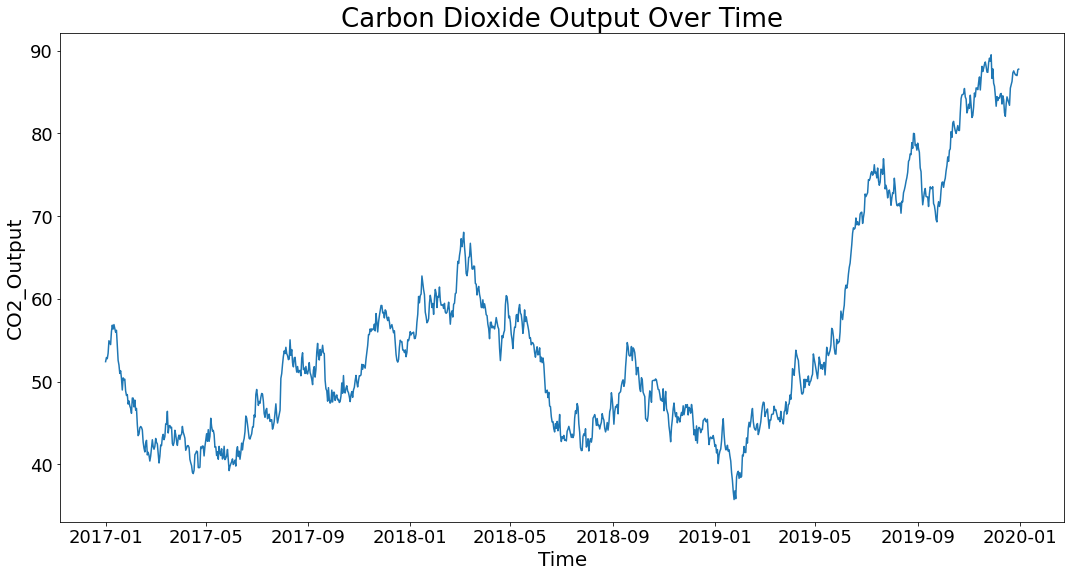

In [15]:
plot_series(df, cols=['co2'], title="Carbon Dioxide Output Over Time", xlab='Time', ylab='CO2_Output')

<details><summary>How would you describe this plot?</summary>
    
    <i>(Answers will vary.)</i>

- Across the full range of time, the value of $Y$ increases.
- There is a sharp jump upward around July 2019.
- $Y$ increases and decreases over time, but in irregular patterns.
- The values of $Y_t$ and $Y_{t-1}$ are highly correlated with one another.
</details>

### Trends

In time series data, a **trend** is the long-term increase or decrease in the data.

The two most common types of trends will be **linear (straight line) trends** and **exponential trends**.

<img src="./images/column_1_small.png" alt="drawing" width="550"/>

<details><summary>Is there a trend in the carbon dioxide output? If so, is it increasing or decreasing? Do you think it's a straight line trend or an exponential trend?</summary>

- Yes, there is a trend in the graph. There appears to be a long-term increase over time.
- The trend could be either linear or exponential!
</details>

We'll decide how to model the above shortly.

### Seasonality

In time series data, **seasonality** describes when a time series is affected by factors that take on a **fixed and known frequency**.

Seasonality does not have to explicitly refer to seasons of the year (and from an inclusivity standpoint, different regions of the world have different seasons), but seasonality almost always **will** be tied to some meaning on the calendar!

<details><summary>Can you think of examples of time series data that exhibit seasonality?</summary>

    
- Sales data for many products likely exhibits seasonality. Purchases of heavier coats will probably peak in colder times of the year, which will occur roughly every twelve months.
- Restaurant sales likely exhibits seasonality with a peak every week (usually Friday or Saturday).
- Temperature itself would exhibit seasonality! We expect temperature to fluctuate up and down in a relatively consistent pattern every twelve months or so.
    - Note that temperature also has an increasing trend... so trends and seasonality can occur together!
</details>

<img src="./images/column_1_small.png" alt="drawing" width="550"/>

<details><summary>Is there seasonality in the carbon dioxide output? If so, about how frequently?</summary>

- No, there does not appear to be seasonality.
- While $Y$ does fluctuate up and down, it does not appear to fluctuate with some fixed and known frequency.
</details>

One tool that _can_ be helpful is the `seasonal_decompose` tool from `statsmodels`. However, we have to be careful!

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

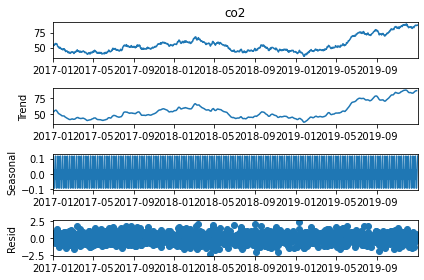

In [17]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df['co2'])

# Plot the decomposed time series.
decomp.plot();

By default, the decomposition will assume there is a linear trend. If you believe there is an exponential trend, you should change the argument `model` to be `multiplicative`, but this will fail with values that are less than or equal to 0.

The plot will **always** pull out a seasonal component... even if there isn't a seasonal component in our data! In short, this is sometimes a helpful tool, but it's not a substitute for plotting your data with a time plot and examining it first.

### Autocorrelation

In time series data, autocorrelation refers to the **correlation of one variable with lagged versions of itself**. (You may also hear the term **serial correlation**.)

You might imagine a dataset that looks like this:

|  **time**  | $Y_t$ | $Y_{t-1}$ | $Y_{t-2}$ | $Y_{t-3}$ | $X_{t}$ |
|-------|-------|-----------|-----------|-----------|---------|
| **1** | $y_1$ | NaN       | NaN       | NaN       | $x_1$   |
| **2** | $y_2$ | $y_1$     | NaN       | NaN       | $x_2$   |
| **3** | $y_3$ | $y_2$     | $y_1$     | NaN       | $x_3$   |
| **4** | $y_4$ | $y_3$     | $y_2$     | $y_1$     | $x_4$   |

In [18]:
# Generate a dataframe with our CO2 data that
# looks like the above dataframe.

df['co2_lag_1'] = df['co2'].shift(1)
df['co2_lag_2'] = df['co2'].shift(2)
df['co2_lag_3'] = df['co2'].shift(3)

In [19]:
df.head()

,co2,co2_lag_1,co2_lag_2,co2_lag_3
2017-01-01,52.400000,NaN,NaN,NaN
2017-01-02,52.896714,52.400000,NaN,NaN
2017-01-03,52.758450,52.896714,52.400000,NaN
2017-01-04,53.406138,52.758450,52.896714,52.400000
2017-01-05,54.929168,53.406138,52.758450,52.896714


We can calculate the correlation between $Y_t$ and $Y_{t-1}$, which tells us how highly correlated values of $Y$ are with the immediately previous value of $Y$.

<details><summary>BONUS: If you want to see the formula for autocorrelation, check here.</summary>
    
$$
\begin{eqnarray*}
Corr(Y_t, Y_{t-k}) = \frac{Cov(Y_t,Y_{t-k})}{Var(Y_t)Var(Y_{t-k})}
\end{eqnarray*}
$$
</details> 

In [20]:
# Calculate the correlations among these columns.
df.corr()

,co2,co2_lag_1,co2_lag_2,co2_lag_3
co2,1.000000,0.997065,0.994184,0.991275
co2_lag_1,0.997065,1.000000,0.997046,0.994150
co2_lag_2,0.994184,0.997046,1.000000,0.997030
co2_lag_3,0.991275,0.994150,0.997030,1.000000


<details><summary>Why do you think it's useful to look at the correlation between our $Y$ variable and lagged versions of itself?</summary>

    
- It can inform us which lagged values of $Y$ to put into our model!
</details>

We can also calculate the correlation between $Y_t$ and $Y_{t-2}$, $Y_t$ and $Y_{t-3}$, and so on. But this can be tedious to do by hand, so we generally use a function to generate an **autocorrelation plot** that visualizes this all at once!

In [21]:
# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf

In [22]:
# Get the autocorrelation values
from statsmodels.tsa.stattools import acf

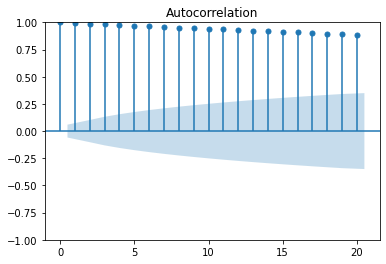

In [23]:
# Generate the ACF plot on co2 data
# up to 20 time periods.
plot_acf(df['co2'], lags=20);

In [24]:
acf(df['co2'], nlags=20)

array([1.        , 0.99399171, 0.9880563 , 0.98222603, 0.97630857,
       0.97064156, 0.96472758, 0.95873184, 0.952716  , 0.94717361,
       0.94152986, 0.93586012, 0.93037091, 0.92469857, 0.9189881 ,
       0.91320041, 0.90762303, 0.90221942, 0.89693269, 0.89113587,
       0.88530715])

### Reading an Autocorrelation Plot

The **horizontal axis** tells us which lag of $Y_t$ we are comparing to the main time series $Y_t$.

The **vertical axis** tells us the value of the autocorrelation between $Y_t$ and the lagged version, $Y_{t-lag}$.

- The left-most value, $lag = 0$ of the autocorrelation plot is $Corr(Y_t, Y_t)$. 
    - This should always be 1!
- The next value, $lag = 1$ of the autocorrelation plot is $Corr(Y_t, Y_{t-1})$.
- The next value of the autocorrelation plot visualizes $Corr(Y_t, Y_{t-2})$.




#### Interpretation

The autocorrelation plot is an important tool for a few reasons:
- **We can use it to detect trends**: When the autocorrelation plot has large and positive values for small lags (e.g. lags 1, 2, 3), this is evidence that a trend exists.
- **We can use it to detect seasonality**: Recall that seasonality means we have fluctuations in our $Y$ variable that occur with a fixed and known frequency. When the autocorrelation plot has larger values for the seasonal lags than other lags, this is evidence that seasonality exists. (Visually, this might look like a scalloped shape.)
- **We can use this plot to inform our modeling choices**, along with a related plot - the partial autocorrelation function plot.

### Partial Autocorrelation

Based on the autocorrelation plot above, we might try to fit a model that looks like this:

$$
\begin{eqnarray*}
Y_t &=& \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \cdots + \beta_{20}Y_{t-20} \\
&=& \beta_0 + \sum_{k=1}^{20}\beta_kY_{t-k}
\end{eqnarray*}
$$



<details><summary>However, this can run into many problems!</summary>

- The more variables we have, the likelier we are to overfit our model to the data.
- $Y_{t-1}$ and $Y_{t-2}$ and $Y_{t-3}$ are all highly correlated with one another, so the inputs to our model in this case aren't independent of one another.
- When we use a variable like $Y_{t-20}$, we effectively decrease our sample size by 20. (If our data are measured year over year, discarding 20 years of data is **a lot of data** to exclude from our model.)
</details>

To avoid this problem, we use the **partial autocorrelation function**.
- The partial autocorrelation is like the autocorrelation in that it checks for the correlation between $Y_t$ and lagged versions of itself.
- However, the partial autocorrelation **controls for all lower-lag autocorrelations**.
    - That is, the partial autocorrelation between $Y_t$ and $Y_{t-2}$ is the correlation between $Y_t$ and $Y_{t-2}$  that has already taken into account the autocorrelation between $Y_t$ and $Y_{t-1}$.
    
    
<details><summary>BONUS: If you want to see the formula for partial autocorrelation, check here.</summary>
    
$$
\begin{eqnarray*}
PartialCorr(Y_t, Y_{t-k}) = \frac{Cov(Y_t,Y_{t-k}|Y_{t-1},Y_{t-2},\ldots,Y_{t-(k-1)})}{Var(Y_t|Y_{t-1},Y_{t-2},\ldots,Y_{t-(k-1)})Var(Y_{t-k}|Y_{t-1},Y_{t-2},\ldots,Y_{t-(k-1)})}
\end{eqnarray*}
$$
</details>     

In [28]:
# Import the partial autocorrelation function (PACF) plot.
from statsmodels.graphics.tsaplots import plot_pacf

/Users/jonathanbeltran/opt/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


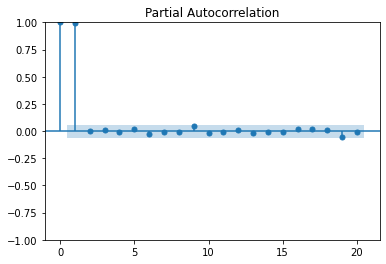

In [31]:
# Generate the PACF plot on CO2 data
# up to 20 time periods.
plot_pacf(df['co2'], lags=20);

### Reading a Partial Autocorrelation Plot

The **horizontal axis** still tells us which lag of $Y_t$ we are comparing to the main time series $Y_t$.

The **vertical axis** tells us the value of the **partial autocorrelation** between $Y_t$ and the lagged version, $Y_{t-lag}$.

The blue band represents a 95% confidence interval. If the value of the partial autocorrelation goes outside the blue band, that means that correlation is statistically significant.

#### Interpretation

The partial autocorrelation plot is an important tool for a few reasons:
- **We can use it to detect seasonality**: Recall that seasonality means we have fluctuations in our $Y$ variable that occur with a fixed and known frequency. When the partial autocorrelation plot has significant values for the seasonal lags, this is evidence that seasonality exists.
- **We can use this plot to inform our modeling choices**: Here, we see that by using $Y_{t-1}$ as a predictor for $Y_t$, we probably won't get much important information if we were to also include $Y_{t-2}$ (or higher order lags) as a predictor.

In [32]:
# Import the PACF 
from statsmodels.tsa.stattools import pacf

In [33]:
# Get the partial autocorrelation function (values)
pacf(df['co2'], nlags=20)

array([ 1.        ,  0.9949003 ,  0.00370283,  0.00696439, -0.01186286,
        0.02125529, -0.0276096 , -0.01132167, -0.00657577,  0.04424644,
       -0.01393762, -0.0048874 ,  0.01373872, -0.01871198, -0.00988272,
       -0.01225839,  0.01856993,  0.01473974,  0.00850168, -0.05456675,
       -0.00414816])

## Recap

When you look at a new time series, you should:
- generate a time plot.
- generate the autocorrelation plot.
- generate the partial autocorrelation plot.

Use these plots to determine:
- is there a trend?
- is there seasonality?

Once we answer these questions, we can begin to model.

## Practice

On your own, take some time to read in the following data and answer the following questions.
1. Based on the time plot, is there evidence of a trend? If so, describe the trend. How can you tell?
2. Based on the time plot, is there evidence of seasonality? If so, estimate the frequency of the seasonality. How can you tell?
3. Based on the ACF plot, is there evidence of a trend? If so, describe the trend. How can you tell?
4. Based on the ACF and PACF plots, is there evidence of seasonality? If so, estimate the frequency of the seasonality. How can you tell?

In [34]:
# Read in airline data.
air = pd.read_csv('./data/airline-passengers.csv', parse_dates=['Month'])

# Set the index to be month over month.

In [35]:
air.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [36]:
air = air.set_index("Month")

In [38]:
air.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


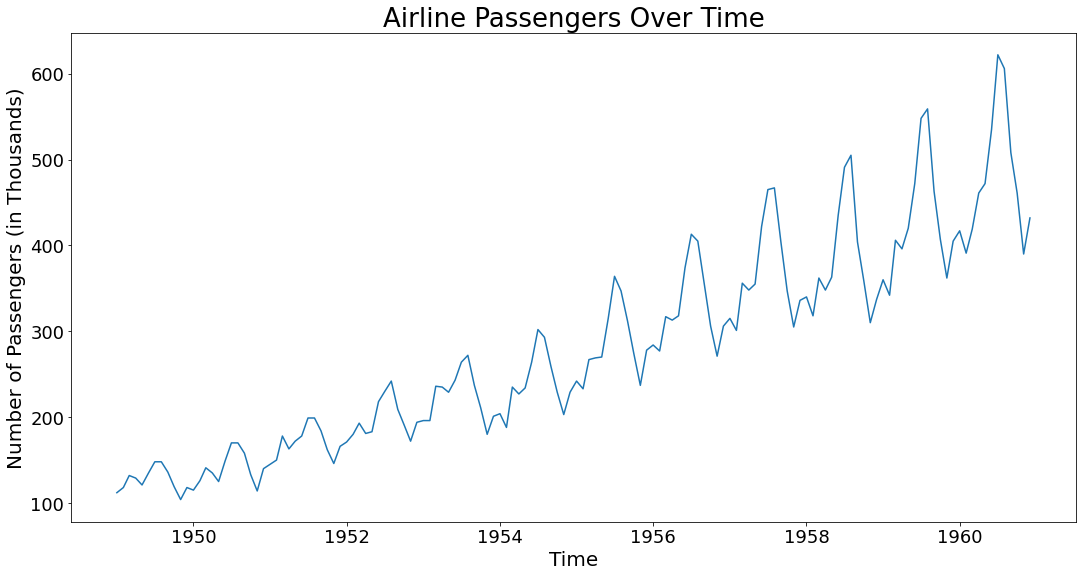

In [39]:
# Generate a time plot of the airline passengers data.
plot_series(air, ['Passengers'], title='Airline Passengers Over Time', 
            xlab='Time', ylab='Number of Passengers (in Thousands)')

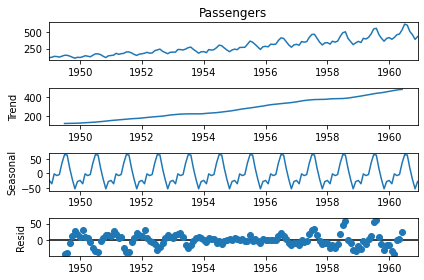

In [40]:
# Generate a decomposition plot of the airline passengers data.
decomp = seasonal_decompose(air['Passengers'])

# Plot the decomposed time series.
decomp.plot();

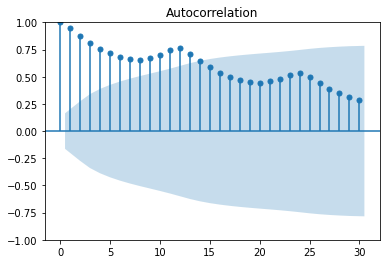

In [41]:
# Generate an ACF plot of the airline passengers data with 30 time periods.
plot_acf(air['Passengers'], lags=30);

/Users/jonathanbeltran/opt/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


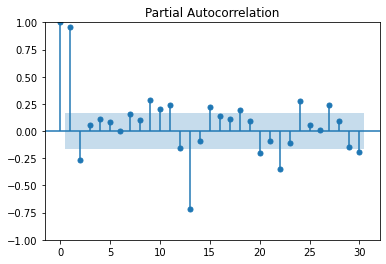

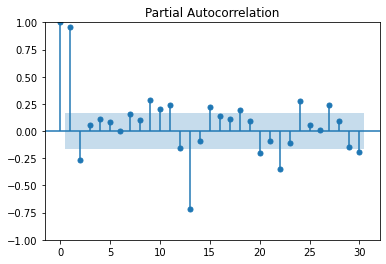

In [42]:
# Generate an PACF plot of the airline passengers data with 30 time periods.
plot_pacf(air['Passengers'], lags=30)

<details><summary>1. Based on the time plot, is there evidence of a trend? If so, describe the trend. How can you tell?</summary>

    
- There is a trend. It seems to be increasing and pretty linear.
</details>

<details><summary>2. Based on the time plot, is there evidence of seasonality? If so, estimate the frequency of the seasonality. How can you tell?</summary>

    
- There is evidence of seasonality. There appear to be peaks in the data about every twelve months. This makes sense, because the number of people flying on planes in a given month may peak when there's more travel (e.g. summer) and it might die down in other months.
- This evidence is strongest in the later years, where from 1954-1961 there's obviously one peak every year. (Note that there are two peaks between 1956 and 1958, two peaks between 1958 and 1960, etc.)
</details>

<details><summary>3. Based on the ACF plot, is there evidence of a trend? If so, describe the trend. How can you tell?</summary>

- Yes, there is a trend. In the ACF plot, the small lag values have large, positive autocorrelations.
</details>

<details><summary>4. Based on the ACF and PACF plots, is there evidence of seasonality? If so, estimate the frequency of the seasonality. How can you tell?</summary>

    
- Yes, there is seasonality. In the ACF plot, there is a "scalloped" shape, where we see ACF values peak roughly every 12 months.
- In the PACF plot, we see significant values every 12 months or so. We also see some positive and some negative significant partial autocorrelations, which usually indicates strong seasonal fluctuations.
</details>

<details><summary>Based on the above plots, we might conclude:</summary>

- The last two values are highly informative in predicting future values.
- There is a linear trend in our data.
- There is seasonality that occurs roughly every twelve months.

Let's fit the following model:
$$
\begin{eqnarray*}
Y_t &=& \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \beta_3Y_{t-12} + \beta_4t
\end{eqnarray*}
$$
</details>

In [43]:
air.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [47]:
# Create a column called `lag_1` that lags Passengers by one month.
air['lag_1'] = air['Passengers'].shift(1)

# Create a column called `lag_2` that lags Passengers by two months.
air['lag_2'] = air['Passengers'].shift(2)

# Create a column called `seasonal_12` that lags Passengers by one year.
air['seasonal_12'] = air['Passengers'].shift(12)

# Create a variable called `time` that takes on a value of 0 in January 1949,
# then increases by 1 each month until the end of the dataframe.
air['time'] = range(0, air.shape[0])

In [50]:
# Confirm the top of our dataframe looks good.
air.head(15)

,Passengers,lag_1,lag_2,seasonal_12,time
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,0
1949-02-01,118,112.0,NaN,NaN,1
1949-03-01,132,118.0,112.0,NaN,2
1949-04-01,129,132.0,118.0,NaN,3
1949-05-01,121,129.0,132.0,NaN,4
1949-06-01,135,121.0,129.0,NaN,5
1949-07-01,148,135.0,121.0,NaN,6
1949-08-01,148,148.0,135.0,NaN,7
1949-09-01,136,148.0,148.0,NaN,8


In [52]:
# Confirm the bottom of our dataframe looks good.
air.tail(15)

,Passengers,lag_1,lag_2,seasonal_12,time
Month,,,,,
1959-10-01,407,463.0,559.0,359.0,129
1959-11-01,362,407.0,463.0,310.0,130
1959-12-01,405,362.0,407.0,337.0,131
1960-01-01,417,405.0,362.0,360.0,132
1960-02-01,391,417.0,405.0,342.0,133
1960-03-01,419,391.0,417.0,406.0,134
1960-04-01,461,419.0,391.0,396.0,135
1960-05-01,472,461.0,419.0,420.0,136
1960-06-01,535,472.0,461.0,472.0,137


## Train-Test Split

Before building a model, we should split our data up into a training and testing set.

Since our goal with time series models is almost always to forecast values forward in time, the idea with a time series train/test split is to train on earlier data and test/evaluate on later data.

Most commonly, we'll set our:
- training set to be the "first" 67% - 80% of our data timewise.
- test set be the "last" 20% - 33% timewise.

Let's split our dataframe by taking the first 80% of rows for training and the rest for testing.

In [ ]:
y.val

In [55]:
X = air.drop(columns=["Passengers"])
y = air["Passengers"]

# Generate train/test split.
# We don't want our data to be randomly shuffled - we want to keep the order!
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False,
                                    test_size = 0.2)

In [58]:
# Check shape to confirm we did this properly.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(115, 4)
(29, 4)
(115,)
(29,)


## Fit a linear model.

In [59]:
# Import statsmodels.
import statsmodels.api as sm

In [63]:
# Before fitting a model in statsmodels, what do we need
# to do? (Hint: Think intercept.)
X_train = sm.add_constant(X_train)

# Confirm.
X_train.head()

,const,lag_1,lag_2,seasonal_12,time
Month,,,,,
1950-01-01,1.0,118.0,104.0,112.0,12
1950-02-01,1.0,115.0,118.0,118.0,13
1950-03-01,1.0,126.0,115.0,132.0,14
1950-04-01,1.0,141.0,126.0,129.0,15
1950-05-01,1.0,135.0,141.0,121.0,16


In [64]:
# statsmodels won't be able to handle missing values.
## Drop NAs from X_train


## Change y_train to match the remaining X_train indices

X_train = X_train.dropna()

y_train = y_train[X_train.index]
# This way we subset y_train to keep only indices from X_train.


print(X_train.shape)

(103, 5)


In [67]:
# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!

lm = sm.OLS(y_train, X_train)

In [71]:
# Then we fit our model.
lm_results = lm.fit()

In [72]:
# Display our summary!
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:             Passengers   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1099.
Date:                Sat, 26 Mar 2022   Prob (F-statistic):           1.88e-80
Time:                        16:08:17   Log-Likelihood:                -408.95
No. Observations:                 103   AIC:                             827.9
Df Residuals:                      98   BIC:                             841.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.5457      4.913      1.536      

In [79]:
# Add an intercept to X_test
X_test = sm.add_constant(X_test)

In [81]:
# Generate predicted test values.
preds = lm.predict(X_test, y_test)

In [82]:
# Import R2 score and MSE.
from sklearn.metrics import r2_score, mean_squared_error

In [83]:
# Calculate R2 score.
r2_score(y_test, preds)

ValueError: Found input variables with inconsistent numbers of samples: [29, 5]

In [84]:
# Calculate RMSE.
mean_squared_error(y_test, preds) ** 0.5

ValueError: Found input variables with inconsistent numbers of samples: [29, 5]

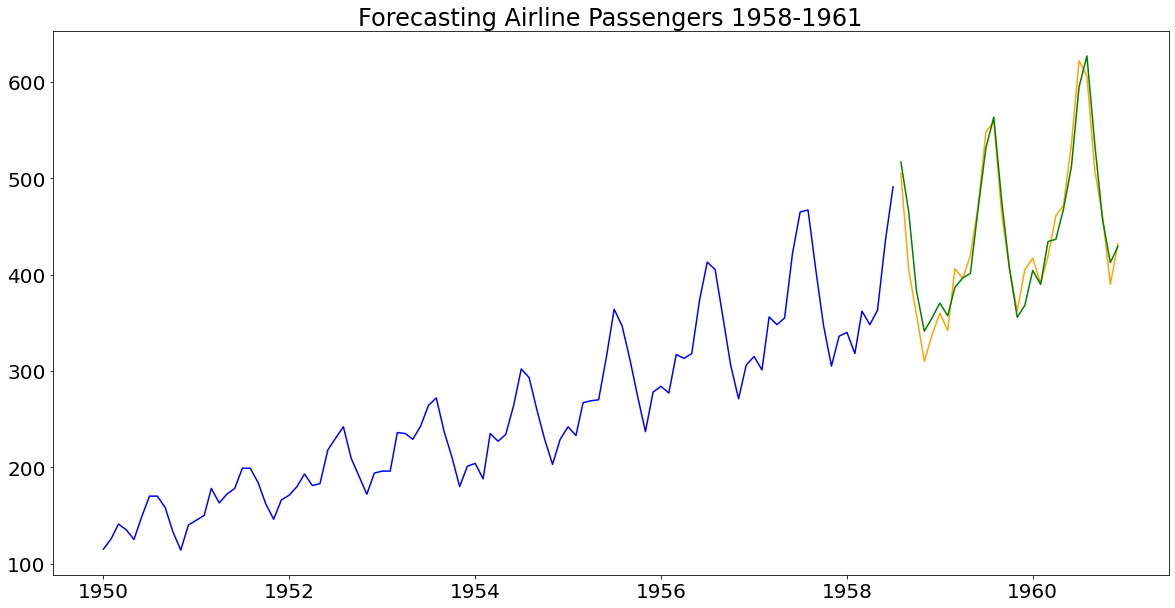

In [85]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green')

# Set label.
plt.title(label = 'Forecasting Airline Passengers 1958-1961', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Learning Objectives 
_By the end of the lesson, students should be able to:_
- Define forecasting.
- Define and identify trend and seasonality in time series data.
- Define and calculate autocorrelation manually.
- Generate and interpret a seasonal decomposition plot.
- Generate and interpret an autocorrelation plot.
- Generate and interpret a partial autocorrelation plot.
- Properly fit, generate predictions from, and evaluate a linear time series model.

In [86]:
accounts = [[1,2,3], [2,3,4]]

In [92]:
max([sum(accounts[x]) for x in range(len(accounts))])

9

In [ ]:
class Solution(object):
    def maximumWealth(self, accounts):
        """
        :type accounts: List[List[int]]
        :rtype: int
        """
        return [sum(accounts[x]) for x in range(len(accounts))]

         wealth = []
        for i in range(len(accounts)):
            wealth.append(sum(accounts[i]))
        
        return max(wealth)

In [122]:
word1 = "a"
word2 = "aa"

In [123]:
set(word1) - set(word2)

set()

In [127]:
counter(word1)

NameError: name 'counter' is not defined

In [128]:
from collections import Counter


In [126]:
l1, l2 = len(word1), len(word2)
l1, l2

(1, 2)

In [137]:
w1 = Counter(word1)

w1.keys()

dict_keys(['a'])

In [120]:
def words(word1, word2):
    l1, l2 = len(word1), len(word 2)
    
    if l1 != l2:
        return False
    
    

In [121]:
words( "cabbba", "abbccc" )

True